In [1]:
import os

# Walk through  directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/input/brain-tumor-mri-dataset/Training"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 4 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset/Training'.
There are 0 directories and 1457 images in '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'.
There are 0 directories and 1595 images in '/kaggle/input/brain-tumor-mri-dataset/Training/notumor'.
There are 0 directories and 1339 images in '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'.
There are 0 directories and 1321 images in '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'.


In [2]:
import numpy as np 
import os
import keras
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/kaggle/input/brain-tumor-mri-dataset/Training") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['glioma' 'meningioma' 'notumor' 'pituitary']


In [4]:
class_labels = ['glioma','meningioma','notumor','pituitary']

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512)


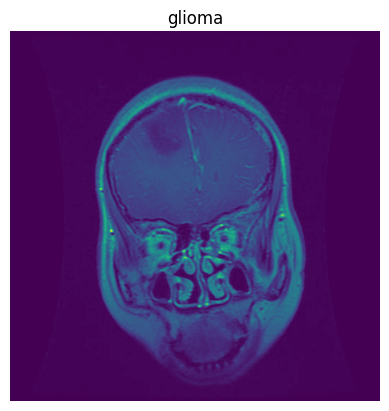

In [6]:
img = view_random_image(target_dir="/kaggle/input/brain-tumor-mri-dataset/Training/",
                        target_class="glioma")

In [7]:
img.shape

(512, 512)

In [8]:
# 1. Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf

# 2. Set the seed for reproducibility
tf.random.set_seed(42)

# 3. Directories for training, validation, and test data
TRAIN_DIR = '/kaggle/input/brain-tumor-mri-dataset/Training'
TEST_DIR = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# 4. Image size and batch size
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

# 5. Data generators for training, validation, and test
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2,  # Split for training and validation
    rotation_range=20,  # Data augmentation by rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(rescale=1./255)

# 6. Create data generators for train, validation, and test sets
train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Training subset
    shuffle=True,
    seed=42
)

val_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Validation subset
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# 7. Load the base model (DenseNet169)
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# 8. Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer for classes

# 9. Final model
model = Model(inputs=base_model.input, outputs=predictions)

# 10. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# 11. Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# 12. Add EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# 13. Train the model with class weights and EarlyStopping
EPOCHS = 6  # Increase number of epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,  # Balance classes
    callbacks=[early_stopping]
)

# 14. Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 15. Predict on test data and generate classification report
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

# Get class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,497,412 (51.49 MB)

 Trainable params: 854,532 (3.26 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 634s 4s/step - accuracy: 0.7343 - loss: 0.7139 - val_accuracy: 0.7923 - val_loss: 0.5785
Epoch 2/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.8942 - loss: 0.3108 - val_accuracy: 0.8142 - val_loss: 0.5006
Epoch 3/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.8937 - loss: 0.2869 - val_accuracy: 0.7572 - val_loss: 0.6915
Epoch 4/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.9032 - loss: 0.2894 - val_accuracy: 0.8151 - val_loss: 0.4451
Epoch 5/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 594s 4s/step - accuracy: 0.9157 - loss: 0.2282 - val_accuracy: 0.8449 - val_loss: 0.4691
Epoch 6/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.9192 - loss: 0.2138 - val_accuracy: 0.8002 - val_loss: 0.5934
41/41 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.8456 - loss: 0.3735
Test Loss: 0.3181096017360687, Test Accuracy: 0.8764302134513855
41/41 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step
Classification Report:
               precision    recall  f1-s

In [9]:
model.save('/kaggle/working/BrainTumor.h5')
import os

# List files in the working directory
print(os.listdir('/kaggle/working'))

['__notebook__.ipynb', 'BrainTumor.h5']


In [10]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



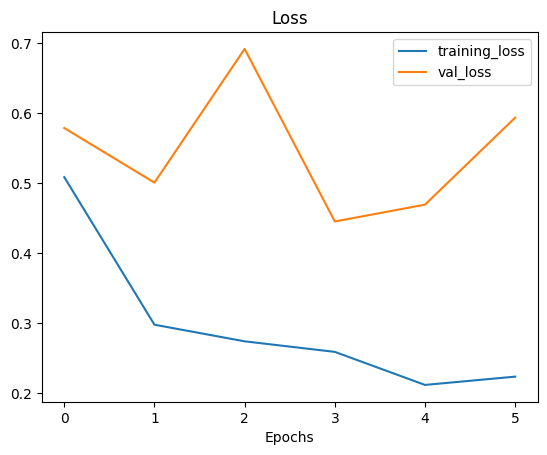

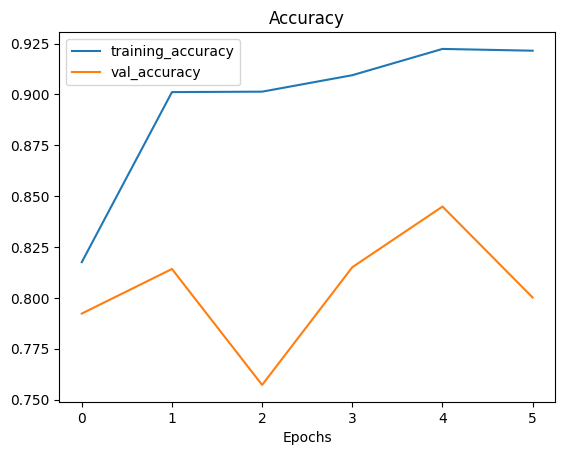

In [11]:
plot_loss_curves(history)

In [12]:
model.save('BrainTumor.h5')

In [13]:
import tensorflow as tf
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size=[img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img / 255.

    # Add batch dimension (model expects shape (batch_size, height, width, channels))
    img = tf.expand_dims(img, axis=0)
    
    return img

In [14]:
test = load_and_prep_image("/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0012.jpg")
import tensorflow as tf
import numpy as np
# Your class labels
class_labels = ['glioma','meningioma','notumor','pituitary']
saved_model = tf.keras.models.load_model('/kaggle/working/BrainTumor.h5')

# Make a prediction on our custom image
prediction=saved_model.predict(test)
predicted_class = np.argmax(prediction, axis=-1)

# Map the predicted class index to the class label
predicted_class_label = class_labels[predicted_class[0]]

print(f"Predicted class: {predicted_class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: glioma


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

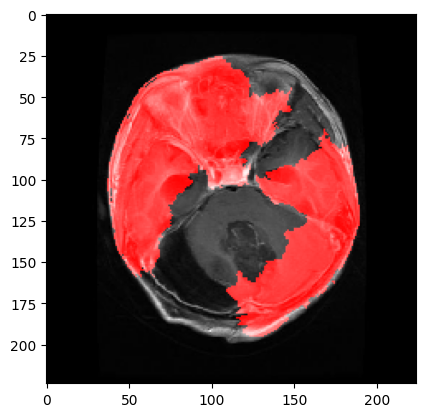

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=[224,224]
import tensorflow as tf
import numpy as np

from lime import lime_image
import matplotlib.pyplot as plt

# Set the seed
TRAIN_DIR = '/kaggle/input/brain-tumor-mri-dataset/Training'
TEST_DIR = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# 4. Image size and batch size
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

# 5. Data generators for training, validation, and test
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2,  # Split for training and validation
    rotation_range=20,  # Data augmentation by rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(rescale=1./255)

# 6. Create data generators for train, validation, and test sets
train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Training subset
    shuffle=True,
    seed=42
)

val_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Validation subset
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)
saved_model = tf.keras.models.load_model('/kaggle/working/BrainTumor.h5')
image_shape = (224,224, 3)

explainer = lime_image.LimeImageExplainer()

# Get a single image and its true label
x_test, y_test = next(test_generator)
image = x_test[0]  # Take the first image in the batch

# Define the predict function for LIME
def predict_fn(images):
    # Normalize images (to match model preprocessing)
    images = images / 255.0  # Ensures images are between 0 and 1
    return saved_model.predict(images)

# Explain the model's prediction on the first image
explanation = explainer.explain_instance(image.astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualize the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

# Display the mask overlaid on the image
plt.imshow(temp)
plt.show()